In [1]:
# ms-python.python added
import os

In [2]:
import glob, shutil
import cv2
import json
import numpy as np
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from datetime import datetime
from pprint import pprint

%load_ext autoreload
%autoreload 2

In [3]:
# set parameters
# crop size
ydim = 256
xdim = 256
crop_per_image = 40
seed = 100
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M")
output_folder = timestamp + '_' + str(crop_per_image) + 'x'
print("Crop Size y: {}".format(ydim))
print("Crop Size x: {}".format(xdim))
print('Crop per Image: {}'.format(crop_per_image))
print('Seed: {}'.format(seed))
print('timestamp: {}'.format(timestamp))

Crop Size y: 256
Crop Size x: 256
Crop per Image: 40
Seed: 100
timestamp: 2019_12_20_16_56


In [4]:
# Prepare the training dataset
# Specify the input folder
# mainpath = '/Volumes/LaCie_DataStorage/PerlmutterData/dl_seg_project_raw'

def listdir_nohidden(dir):
    return [file for file in os.listdir(dir) if not file.startswith('.')]

mainpath = os.path.join('D:', 'PerlmutterData', 'dl_seg_project_raw')
img_seg_dir = 'data_Amira'
labeltypes = listdir_nohidden(os.path.join(mainpath, img_seg_dir))
input_path = os.path.join(mainpath, img_seg_dir)
print(labeltypes)

['autophagosome', 'cell_membrane', 'nucleus']


In [5]:
# Create output folder
print("Check the output folder:")
dir_checker('data_crop', mainpath)
dir_checker(output_folder, os.path.join(mainpath, 'data_crop'))
output_path = os.path.join(mainpath, 'data_crop', output_folder)
print(output_path)

Check the output folder:
data_crop exists in D:PerlmutterData\dl_seg_project_raw
2019_12_20_16_56_40x does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop
D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x


In [6]:
# create parameter
pars = dict(
            mainpath = mainpath,
            output_folder = output_folder,
            output_path = output_path,
            img_seg_dir = img_seg_dir,
            labeltypes = labeltypes,
            input_path = input_path, 
            ydim = ydim,
            xdim = xdim, 
            crop_per_image = crop_per_image,
            )

with open(os.path.join(output_path, 'pars_' + timestamp + '.json'), 'w') as outfile:
    json.dump(pars, outfile, indent=4)

In [7]:
data_path = [os.path.join(input_path, labeltype) for labeltype in labeltypes ]
print("Path: {}".format(data_path))

Path: ['D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome', 'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane', 'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\nucleus']


In [8]:
# create list for filenames
ipimglist = {}
iplabellist = {}

for labeltype in labeltypes:
    imglist_tmp = glob.glob(os.path.join(input_path, labeltype, 'images', '*', '*.tif'), recursive=True)
    labellist_tmp = glob.glob(os.path.join(input_path, labeltype, 'labels', '*', '*.tif'), recursive=True)
    ipimglist[labeltype] = imglist_tmp
    iplabellist[labeltype] = labellist_tmp


In [9]:
pprint(ipimglist)
# pprint(iplabellist)

{'autophagosome': ['D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image00.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image01.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image02.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image03.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image04.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_label03_stack01\\image05.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\autophagosome\\images\\data_d00_batch01_loc01_la

                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image19.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_label01_stack01\\image00.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_label01_stack01\\image01.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_label01_stack01\\image02.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_label01_stack01\\image03.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_label01_stack01\\image04.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d07_batch01_loc01_la

In [10]:
imgcount = 0
for item in ipimglist.items():
    imgcount = imgcount + len(item[1])
labelcount = 0
for item in iplabellist.items():
    labelcount = labelcount + len(item[1])
    
print("Input Image Counts: {}".format(imgcount))
print("Input Label Counts: {}".format(labelcount))
print("Final Image/Label Counts: {}".format(imgcount * crop_per_image))

Input Image Counts: 541
Input Label Counts: 541
Final Image/Label Counts: 21640


In [11]:
imgtypes = ['images', 'labels']
for imgtype in imgtypes:
    dir_checker(imgtype, output_path)
    for labeltype in labeltypes:
        dir_checker(labeltype, os.path.join(output_path, imgtype))

images does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x
autophagosome does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\images
cell_membrane does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\images
nucleus does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\images
labels does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x
autophagosome does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\labels
cell_membrane does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\labels
nucleus does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_20_16_56_40x\labels


In [12]:
# Batch Random Crop
for labeltype in labeltypes:     
    print("Croping the images from group {}...".format(labeltype))
    random_crop_batch(ipimglist = ipimglist, 
                      iplabellist = iplabellist, 
                      opfolder = output_path, 
                      label = labeltype, 
                      crop_size = [ydim, xdim], 
                      crop_per_image = crop_per_image, 
                      crop_outside = False,
                      seed = seed)
    print("Finish")


Croping the images from group autophagosome...


C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



Finish
Croping the images from group cell_membrane...



Finish
Croping the images from group nucleus...



Finish


In [13]:
from imutils import paths
# image checker:
check_label = 'nucleus'

opimglist = list(paths.list_images(os.path.join(output_path, 'images', check_label)))
print(len(opimglist))
oplabellist = list(paths.list_images(os.path.join(output_path, 'labels', check_label)))
print(len(oplabellist))

9240
9240


In [14]:
image_count = 10
img_number_list = np.arange(len(opimglist))
np.random.shuffle(img_number_list)
img_number_list = img_number_list[:image_count]
print(img_number_list)

[2097 2814 6419 1503 8295 5262 4377 1582 6055 4829]


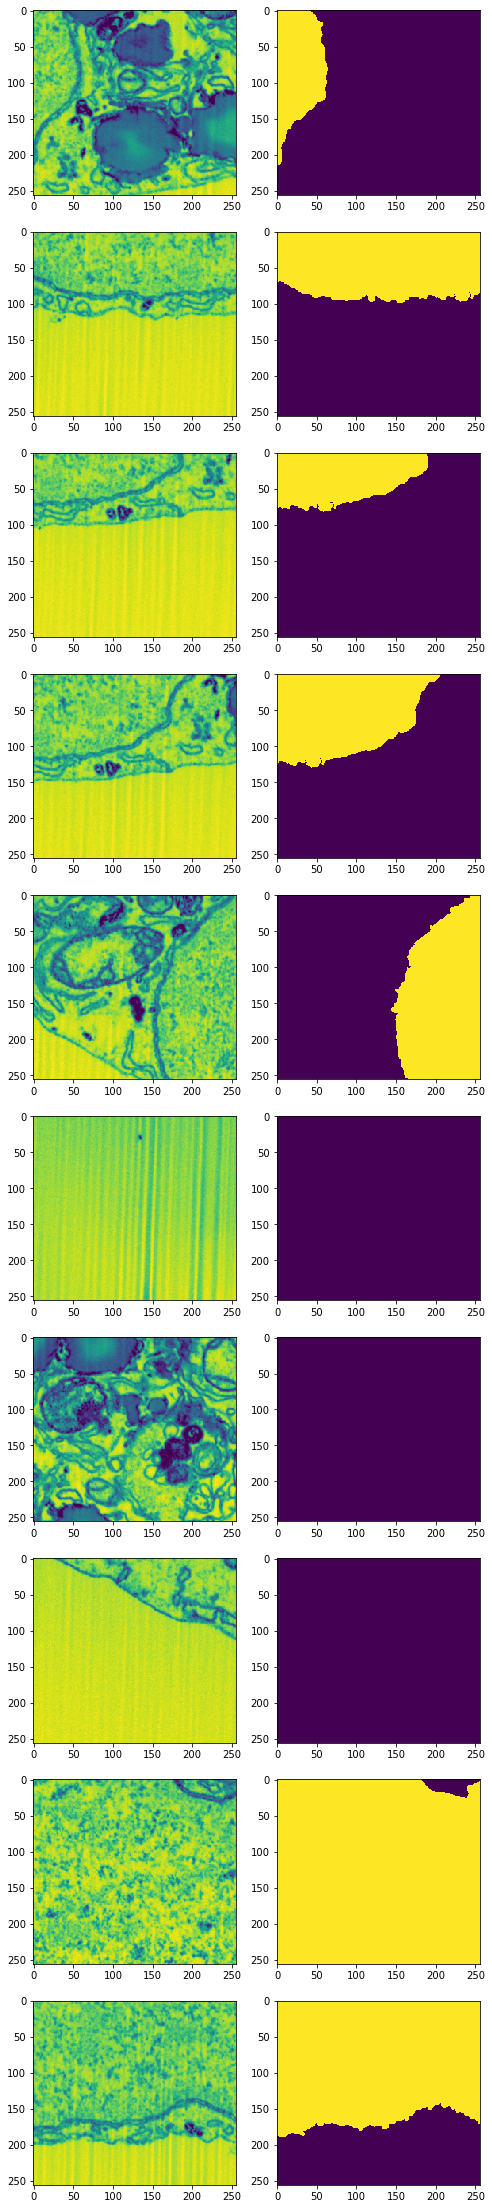

In [15]:
fig = plt.figure(figsize=(8, 40))

for idx, img_idx in enumerate(img_number_list):
    img_tmp = imread(opimglist[idx], as_gray = True)
    label_tmp = imread(oplabellist[idx], as_gray=True)
    
    a = fig.add_subplot(image_count, 2, idx*2 + 1)
    imgplot = plt.imshow(img_tmp, aspect='auto')
    
    a = fig.add_subplot(image_count, 2, idx*2 + 2)
    imgplot = plt.imshow(label_tmp, vmin=0, vmax=1, aspect='auto')